In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
def pkl_process(data=None, file=None, mode="dump"):
    f_mode = "wb" if mode == "dump" else "rb"
    load_data = None
    
    with open(file, f_mode) as f:
        if mode == "dump":
            pickle.dump(data, f)
        else:
            load_data = pickle.load(f)
    
    return load_data

In [15]:
seed = 13

# load categorized data and split train, test

In [16]:
df = pd.read_csv("categorized_NAFLD.csv")
df = df.drop(columns=['Unnamed: 0'])
df.shape

(488, 32)

In [17]:
df.head()

,NGT_IFG_,NGT__PRE,DM_STATU,MS,AGE,GNDR,ETHNICIT,BMI,HOMA,SBP,...,AST_M0,ALT_M0,BILIRRUB,PLATELET,ALBUMIN,TSH,MEAN_FPG,NASH_OU2,FIBROSI2,NAFLD_OU
0,0,0,1,0,0,0,0,2,0,1,...,0,0,0,1,1,0,2,0,0,0
1,1,2,0,1,2,1,2,3,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,1,2,1,2,2,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,1,0,1,0,0,3,1,1,...,0,0,0,1,1,0,2,0,0,0
4,0,0,1,1,3,1,0,2,1,1,...,0,0,0,1,1,0,2,0,0,0


In [18]:
# split the data fram to train and test and shuffle
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
train_df.shape, test_df.shape, len(train_df[train_df['NAFLD_OU'] == 1]), len(train_df[train_df['NAFLD_OU'] == 0]), len(test_df[test_df['NAFLD_OU'] == 1]), len(test_df[test_df['NAFLD_OU'] == 0])

((390, 32), (98, 32), 278, 112, 64, 34)

In [19]:
train_df.head()

,NGT_IFG_,NGT__PRE,DM_STATU,MS,AGE,GNDR,ETHNICIT,BMI,HOMA,SBP,...,AST_M0,ALT_M0,BILIRRUB,PLATELET,ALBUMIN,TSH,MEAN_FPG,NASH_OU2,FIBROSI2,NAFLD_OU
268,0,0,1,1,2,1,0,2,0,1,...,0,0,1,1,1,0,1,1,0,1
444,0,0,1,1,1,1,2,3,1,1,...,0,0,1,1,1,0,2,1,0,1
118,3,1,0,0,2,0,3,1,2,0,...,0,0,0,0,1,1,0,0,0,0
449,0,0,1,1,2,1,3,3,1,1,...,1,1,0,1,1,0,2,0,0,1
207,0,0,1,1,1,0,3,3,2,0,...,1,1,0,1,0,0,0,0,0,1


In [20]:
#get training y label
train_y_nash, train_y_fib, train_y_nafld = np.array(train_df['NASH_OU2']), np.array(train_df['FIBROSI2']), np.array(train_df['NAFLD_OU'])
train_y_nafld[:5]

array([1, 1, 0, 1, 1])

In [21]:
train_X = train_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
train_X.shape, train_y_nafld.shape

((390, 29), (390,))

In [22]:
test_y_nash, test_y_fib, test_y_nafld = np.array(test_df['NASH_OU2']), np.array(test_df['FIBROSI2']), np.array(test_df['NAFLD_OU'])
test_X = test_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
test_X.shape, test_y_nafld.shape

((98, 29), (98,))

# data encoding

## one-hot encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [23]:
ohe.fit(df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU']))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [24]:
train_X_ohe = ohe.transform(train_X).toarray()
test_X_ohe = ohe.transform(test_X).toarray()
train_X_ohe.shape, test_X_ohe.shape

((390, 73), (98, 73))

## feature hashing

In [ ]:
from sklearn.feature_extraction import FeatureHasher
#convert data to uni-feature space then feature hashing (libsvm format first -> convert to dict)

# machine learning 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

/Users/alexgre/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [59]:
def get_binary_cls_precision_recall_f1(true_labels, pred_probs, pos_idx, threshold=0.5):
    pred_lables = []
    for pred_prob in pred_probs:
        pos_prob = pred_prob[pos_idx]
        if pos_prob >= threshold:
            pred_lables.append(1)
        else:
            pred_lables.append(0)
    return precision_recall_fscore_support(true_labels, pred_lables, average='binary')

## Logistic Regression

###  OHE as features

In [13]:
def get_cutoff(fpr, tpr, thresholds):
    opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    return thresholds[opt_idx]

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    4.6s finished


{'C': 0.1, 'max_iter': 50, 'random_state': 13, 'solver': 'liblinear', 'tol': 1e-05}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=13, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)


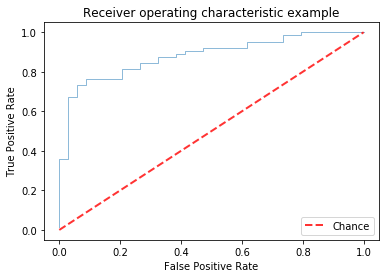

AUC_ROC_score:  0.8818933823529411  cutoff:  0.7325190449228863


In [42]:
# AUC_ROC
tuned_parameters = {'max_iter':[50, 100, 500], 'tol':[0.00001, 0.0001, 0.001, 0.01],'random_state':[seed], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
                    'solver':['lbfgs', 'liblinear', 'newton-cg']}
gs = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1) #scoring='roc_auc'
gs.fit(train_X_ohe, train_y_nafld)
print(gs.best_params_)
print(gs.best_estimator_)
clf = gs.best_estimator_
clf.fit(train_X_ohe, train_y_nafld)
pred_result = clf.predict_proba(test_X_ohe)
idx = list(filter(lambda x: x==1, clf.classes_))[0]
pred_result_1 = list(map(lambda x: x[idx], pred_result))
fpr, tpr, thresholds = roc_curve(test_y_nafld, pred_result_1)
plt.plot(fpr, tpr, lw=1, alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
cut_off = get_cutoff(fpr, tpr, thresholds)
print("AUC_ROC_score: ", roc_auc_score(test_y_nafld, pred_result_1), " cutoff: ", cut_off)

In [ ]:
'''
random_state in train_test_split
random_state=43, AUC_ROC_score:  0.9181372549019607  cutoff:  0.589327937535999
random_state=13, AUC_ROC_score:  0.8818933823529411  cutoff:  0.7325190449228863
random_state=23, AUC_ROC_score:  0.8180821917808219  cutoff:  0.6482708195516653
random_state=37, AUC_ROC_score:  0.7571014492753624  cutoff:  0.6753595392344012
'''

In [37]:
# CV on train + test
l1=list(train_X_ohe)+list(test_X_ohe)
l2=list(train_y_nafld)+list(test_y_nafld)

l = list(zip(l1, l2))
np.random.seed(seed)
np.random.shuffle(l, )

X = list(map(lambda x: x[0], l))
y = list(map(lambda x: x[1], l))

cv_res = cross_val_score(clf, X, y, cv=5, n_jobs=1, scoring="roc_auc")
cv_res, np.average(cv_res)

(array([0.86183575, 0.88105947, 0.8351927 , 0.85141988, 0.84381339]),
 0.8546642365091962)

In [60]:
#precision, recall, f1-score based on cut-off decided from ROC_AUC
get_binary_cls_precision_recall_f1(test_y_nafld, pred_result, list(filter(lambda x: x==1, clf.classes_))[0], cut_off)

(0.9423076923076923, 0.765625, 0.8448275862068965, None)

### feature hashing as features

## SVM

## random forest

## XGBoost

# feature elimination